In [28]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
sim_info = f'/data01/homes/dipiano/E4/irf_random/crab/map_100s_200x200/merged_simulator_data.dat'
map_info = f'/data01/homes/dipiano/E4/irf_random/crab/map_100s_200x200/merged_mapper_data.dat'

# dataset 
filename = '/data01/homes/dipiano/E4/irf_random/crab/cleaner_100s_5sgm_5000sz_200x200_YESnorm_NOstretch.npy'
ds = np.load(filename, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Classes: {ds.keys()}\n")
print(f"NOISY dataset size: {len(ds['DS1'])}")
print(f"CLEAN dataset size: {len(ds['DS2'])}")

print(ds['DS1'][0].shape)

Classes: dict_keys(['DS1', 'DS2'])

NOISY dataset size: 5000
CLEAN dataset size: 5000
(200, 200)


In [29]:
from astroai.tools.utils import split_noisy_dataset

train_noisy, train_clean, test_noisy, test_clean = split_noisy_dataset(ds, split=80, reshape=True, binning=200)

print(f"Train clean: {train_clean.shape}")
print(f"Train noisy: {train_noisy.shape}")
print(f"\nTest clean: {test_clean.shape}")
print(f"Test labenoicyls: {test_noisy.shape}")

Train clean: (4000, 200, 200, 1)
Train noisy: (4000, 200, 200, 1)

Test clean: (1000, 200, 200, 1)
Test labenoicyls: (1000, 200, 200, 1)


In [30]:
sim_data = pd.read_csv(sim_info, sep=' ', header=0).sort_values(by=['seed'])
sim_data.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
15000,crab_00001,1,0,100,100,57.265654,30.447065,57.253328,30.454269,0.012838,North_z40_S_0.5h_LST,2.5,7.322825
15001,crab_00002,2,0,100,100,98.177801,40.950640,98.016897,41.081760,0.178695,North_z60_N_50h_LST,2.5,6.762409
15002,crab_00003,3,0,100,100,76.984211,-66.348920,78.358890,-67.138246,0.957894,North_z40_N_5h_LST,2.5,7.029939
15003,crab_00004,4,0,100,100,125.495725,-44.424075,126.479118,-43.608941,1.079135,North_z40_5h_LST,2.5,7.074566
15004,crab_00005,5,0,100,100,214.162576,42.736282,215.790559,43.357500,1.342109,North_z20_5h_LST,2.5,7.087336


In [31]:
map_data = pd.read_csv(map_info, sep=' ', header=0).sort_values(by=['seed'])
map_data.head()

,name,seed,exposure,center_on,pixelsize,smooth,map_time
20000,crab_00001,1,100,pointing,0.025,5,0.784925
20001,crab_00002,2,100,pointing,0.025,5,0.671861
20002,crab_00003,3,100,pointing,0.025,5,0.751750
20003,crab_00004,4,100,pointing,0.025,5,0.767258
20004,crab_00005,5,100,pointing,0.025,5,0.695176


4733


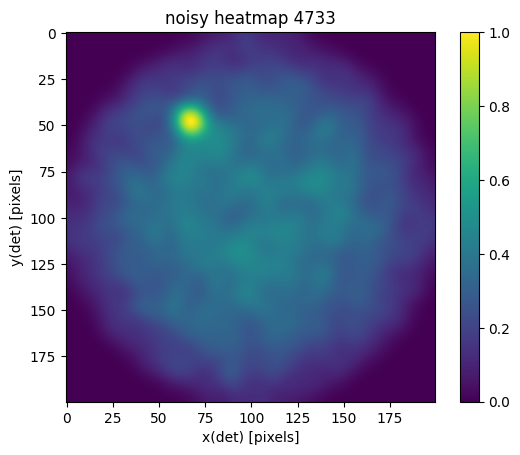

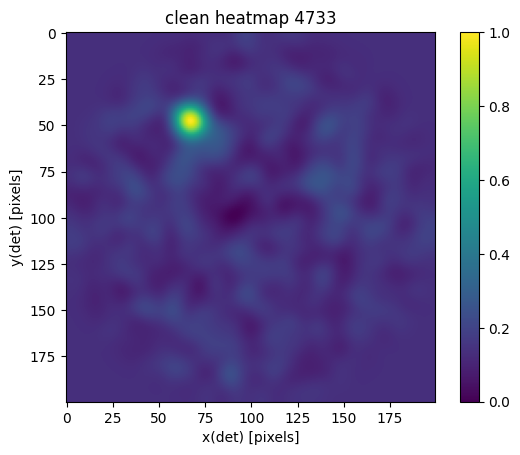

In [57]:
from astroai.tools.utils import plot_heatmap

idx = np.random.choice(range(len(test_noisy)))
#idx = 238
# find seed to get the original heatmap
seed = len(train_noisy) + idx + 1
print(seed)

plot_heatmap(test_noisy[idx], title=f'noisy heatmap {seed}', show=True, save=False, save_name=None)
plot_heatmap(test_clean[idx], title=f'clean heatmap {seed}', show=True, save=False, save_name=None)

## Load model and weights

In [58]:
import tensorflow as tf

savename = 'cleaner_200x200_filter12_2kp' 
model = tf.keras.models.load_model(f'../models/{savename}.keras')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 12)      60        
                                                                 
 average_pooling2d (AverageP  (None, 100, 100, 12)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 12)      588       
                                                                 
 average_pooling2d_1 (Averag  (None, 50, 50, 12)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 12)        588   

In [59]:
# load from checkpoints (if need to)
#model.load_weights('../models/checkpoints/cnn_clean_20231221T124633')

32/32 [==============================] - 2s 55ms/step


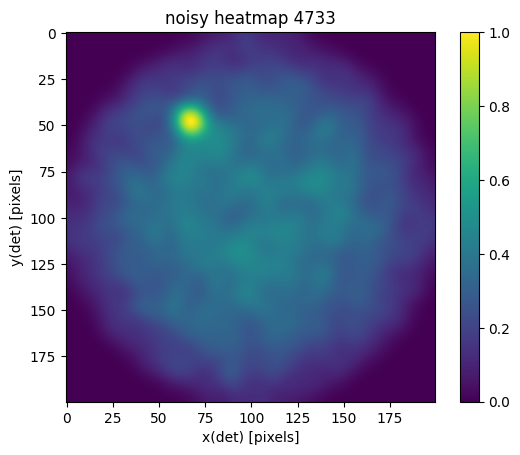

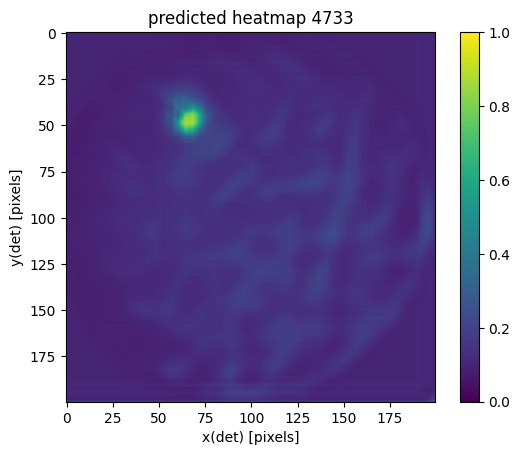

In [60]:
predictions = model.predict(test_noisy)

# plot noisy and prediction
plot_heatmap(test_noisy[idx], title=f'noisy heatmap {seed}', show=True)
plot_heatmap(predictions[idx], title=f'predicted heatmap {seed}', show=True)

# Revert normalisation

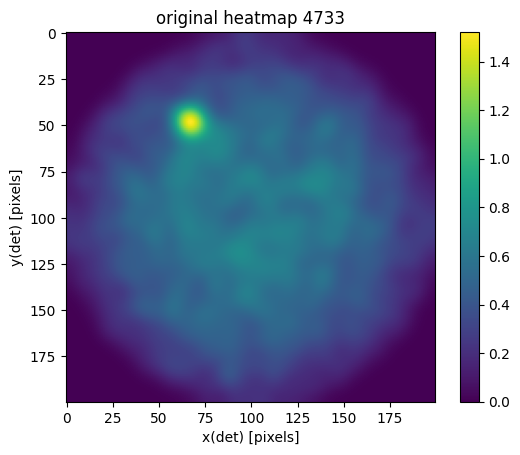

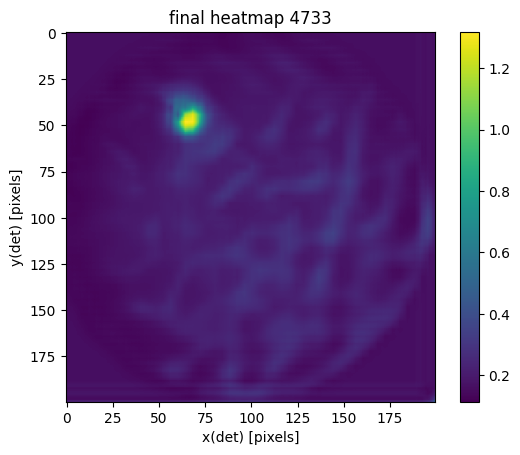

In [61]:
import numpy as np
from astropy.table import Table
from astroai.tools.utils import revert_normalise_heatmap
from astroai.tools.utils import extract_heatmap_from_table, normalise_heatmap

original = f'/data01/homes/dipiano/E4/irf_random/crab/sim/crab_{seed:05d}.fits'
original_heatmap = Table.read(original, hdu=1).to_pandas()
original_heatmap = extract_heatmap_from_table(original_heatmap, trange=[0, 100], smoothing=5, nbins=200)
plot_heatmap(np.rot90(original_heatmap), title=f'original heatmap {seed}', show=True, vnorm=False)

revert_cnn_heatmap = revert_normalise_heatmap(predictions[idx], original_heatmap)
plot_heatmap(revert_cnn_heatmap, title=f'final heatmap {seed}', show=True, vnorm=False)

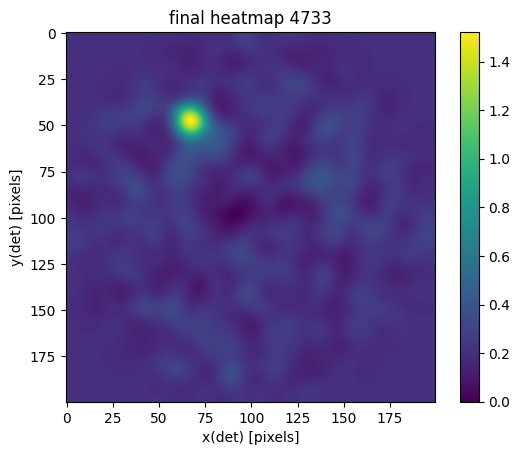

In [62]:
revert_ctools_heatmap = revert_normalise_heatmap(test_clean[idx], original_heatmap)
plot_heatmap(revert_ctools_heatmap, title=f'final heatmap {seed}', show=True, vnorm=False)

In [63]:
np.max(original_heatmap), np.max(revert_ctools_heatmap), np.max(revert_cnn_heatmap)

(1.5210671498659967, 1.5210671498659967, 1.3176707)

# Plot loss

In [64]:
loss = model.evaluate(test_noisy, test_clean, verbose=2)

32/32 - 2s - loss: 0.3715 - 2s/epoch - 56ms/step


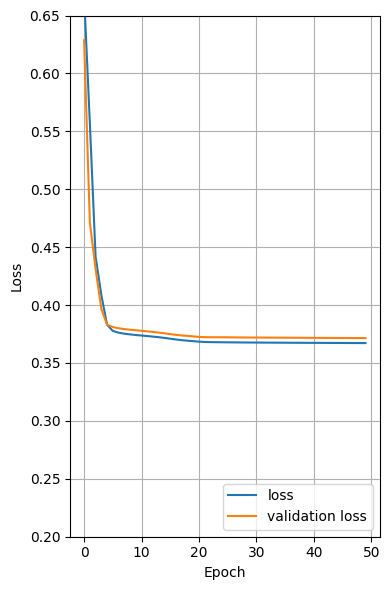

In [65]:
import matplotlib.pyplot as plt

history = np.load(f'/data01/homes/dipiano/astroAI/astroai/models/{savename}_history.npy', 
                  allow_pickle='TRUE').item()


fig, ax = plt.subplots(figsize=(4, 6))

ax.plot(history['loss'], label='loss')
ax.plot(history['val_loss'], label = 'validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_ylim([0.2,0.65])
ax.grid()
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Create SRC and PNT coordinates

In [66]:
row = sim_data[sim_data['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
19732,crab_04733,4733,0,100,100,178.051064,22.048718,176.661535,22.878999,1.529119,North_z40_S_0.5h_LST,2.5,7.006456


In [67]:
from astroai.tools.utils import set_wcs
from astropy.coordinates import SkyCoord

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)
point_ref, pixelsize

(100.0125, 0.025)

In [68]:
source_x, source_y = w.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0], 
                                                  unit='deg', frame='icrs'))
point_x, point_y = w.world_to_pixel(SkyCoord(row['point_ra'].values[0], row['point_dec'].values[0], 
                                                  unit='deg', frame='icrs'))

source_x, source_y, point_x, point_y

(array(47.5041605), array(66.05663988), array(99.025), array(99.025))

In [69]:
source_pix = {'ra': source_x, 'dec': source_y}
point_pix = {'ra': point_x, 'dec': point_y}
source_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
point_deg = {'ra': row['point_ra'].values[0], 'dec': row['point_dec'].values[0]}

source_pix, point_pix, source_deg, point_deg

({'ra': array(47.5041605), 'dec': array(66.05663988)},
 {'ra': array(99.025), 'dec': array(99.025)},
 {'ra': 178.0510637724036, 'dec': 22.04871767699558},
 {'ra': 176.6615350942345, 'dec': 22.878998708203827})

# DL3 photometry

In [70]:
from rtasci.aph.utils import heatmap_photometrics_counts, photometrics_counts

# photometry on DL3
dl3_ph = photometrics_counts(events_list=original, events_type='events_filename',
                             pointing=point_deg, true_coords=source_deg, region_rad=0.2, 
                             skip_adjacent=False, min_regions_number=2)
'''
original_ph = heatmap_photometrics_counts(events_list=original_heatmap, events_type='events_list', 
                                          pointing=point_deg, true_coords=source_deg, region_rad=0.2, 
                                          skip_adjacent=False, min_regions_number=2, binning=200)
predicted_ph = heatmap_photometrics_counts(events_list=revert_norm_heatmap, events_type='events_list', 
                                           pointing=point_deg, true_coords=source_deg, region_rad=0.2, 
                                           skip_adjacent=False, min_regions_number=2, binning=200)


original_ph, predicted_ph'''

dl3_ph

{'on': 336,
 'off': 2112,
 'alpha': 0.047619047619047616,
 'excess': 235.42857142857144,
 'regions': [{'ra': 178.14197568500072, 'dec': 22.49624583416819, 'rad': 0.2},
  {'ra': 178.18984138476884, 'dec': 22.92883832782428, 'rad': 0.2},
  {'ra': 178.11389279806536, 'dec': 23.357393111906354, 'rad': 0.2},
  {'ra': 177.92028282770136, 'dec': 23.74719122652152, 'rad': 0.2},
  {'ra': 177.62469660203288, 'dec': 24.066653546642303, 'rad': 0.2},
  {'ra': 177.25108075914463, 'dec': 24.289899135008092, 'rad': 0.2},
  {'ra': 176.82970343264842, 'dec': 24.398841961742125, 'rad': 0.2},
  {'ra': 176.39470210750954, 'dec': 24.384656126930352, 'rad': 0.2},
  {'ra': 175.98131800403823, 'dec': 24.24849088254281, 'rad': 0.2},
  {'ra': 175.62304104380783, 'dec': 24.001377526873895, 'rad': 0.2},
  {'ra': 175.3488966953811, 'dec': 23.663335714360183, 'rad': 0.2},
  {'ra': 175.18109450346827, 'dec': 23.261751582239466, 'rad': 0.2},
  {'ra': 175.13322880370015, 'dec': 22.829159088583374, 'rad': 0.2},
  {'ra':

# Residuals

In [71]:
# clean the all DS NOISY
#ds['DS3'] = model.predict(np.concatenate((train_noisy, test_noisy)))

residuals = {'STD': [], 'CNN': []}

for noisy, clean, pred in zip(test_noisy, test_clean, predictions):
    residuals['STD'].append(noisy - clean)
    residuals['CNN'].append(noisy - pred)
    
len(residuals['STD']), len(residuals['CNN'])

(1000, 1000)

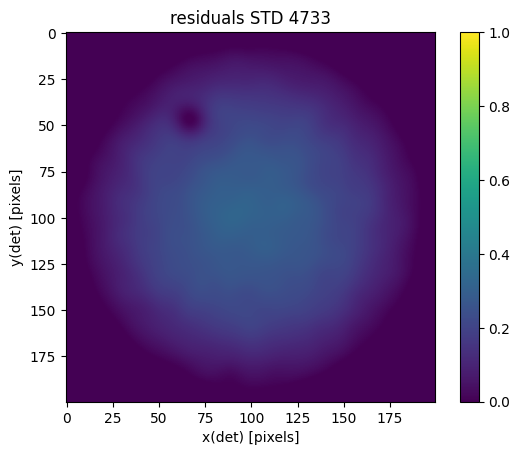

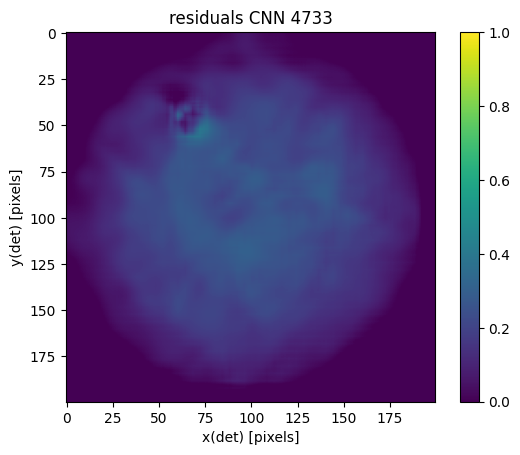

In [72]:
plot_heatmap(residuals['STD'][idx], title=f'residuals STD {seed}', show=True, vnorm=True)
plot_heatmap(residuals['CNN'][idx], title=f'residuals CNN {seed}', show=True, vnorm=True)

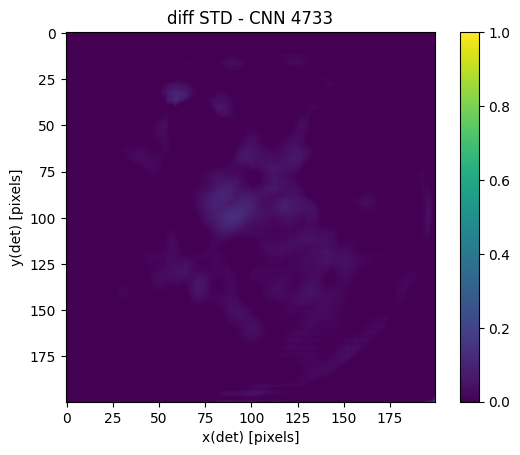

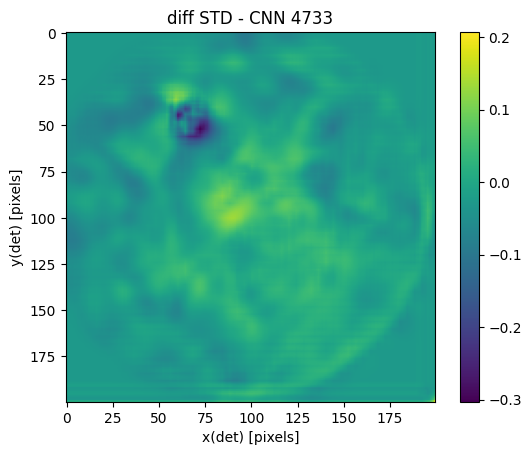

In [73]:
diff = residuals['STD'][idx] - residuals['CNN'][idx]
plot_heatmap(diff, title=f'diff STD - CNN {seed}', show=True, vnorm=True)
plot_heatmap(diff, title=f'diff STD - CNN {seed}', show=True, vnorm=False)

In [74]:
sum_hist = {'STD': [], 'CNN': []}
for std, cnn in zip(residuals['STD'], residuals['CNN']):
    sum_hist['STD'].append(np.sum(std))
    sum_hist['CNN'].append(np.sum(cnn))
    
sum_hist.keys()

dict_keys(['STD', 'CNN'])

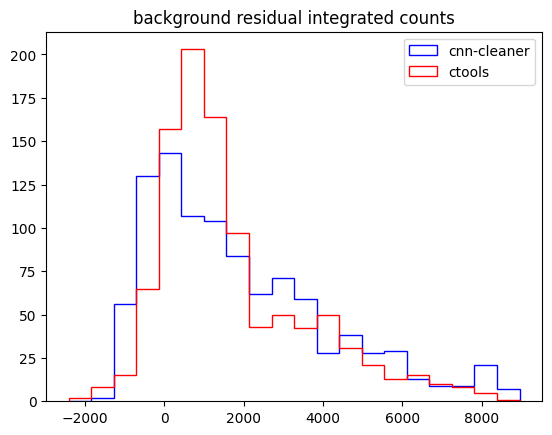

In [75]:
data = (sum_hist['STD'], sum_hist['CNN'])
colors = ['red', 'blue']
plt.title('background residual integrated counts')
plt.hist(data, 20, density=False, histtype='step', 
         color=colors, label=['ctools', 'cnn-cleaner'])
plt.legend()
plt.show()

# extract on source counts

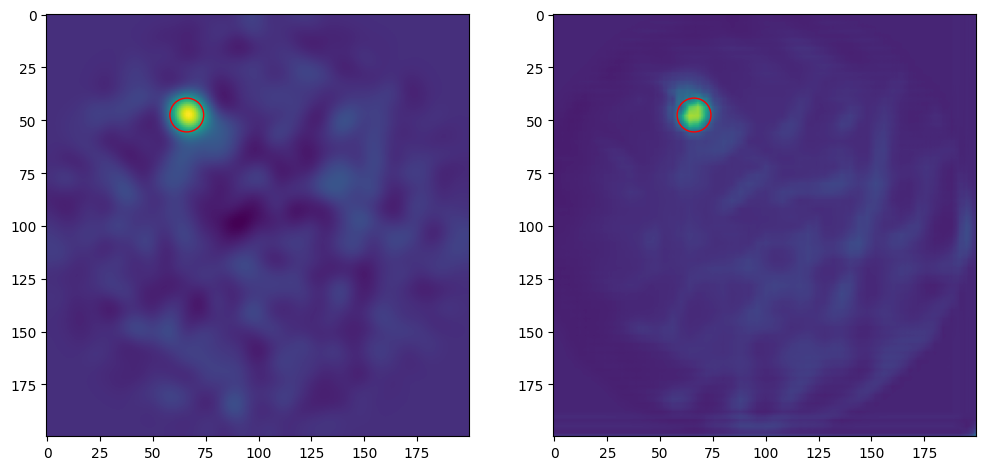

In [76]:
from matplotlib.patches import Circle

y, x = source_y, source_x
yx = source_y, source_x
radius_pix = 0.2/0.025
# on_region = Circle(xy, radius=radius_pix)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
# STD cleaning
ax[0].imshow(test_clean[idx], vmin=0, vmax=1)
ax[0].add_patch(plt.Circle(yx, radius=radius_pix, edgecolor='r', facecolor='none'))

# CNN cleaning
ax[1].imshow(predictions[idx], vmin=0, vmax=1)
ax[1].add_patch(plt.Circle(yx, radius=radius_pix, edgecolor='r', facecolor='none'))


plt.show()

# Create on source mask

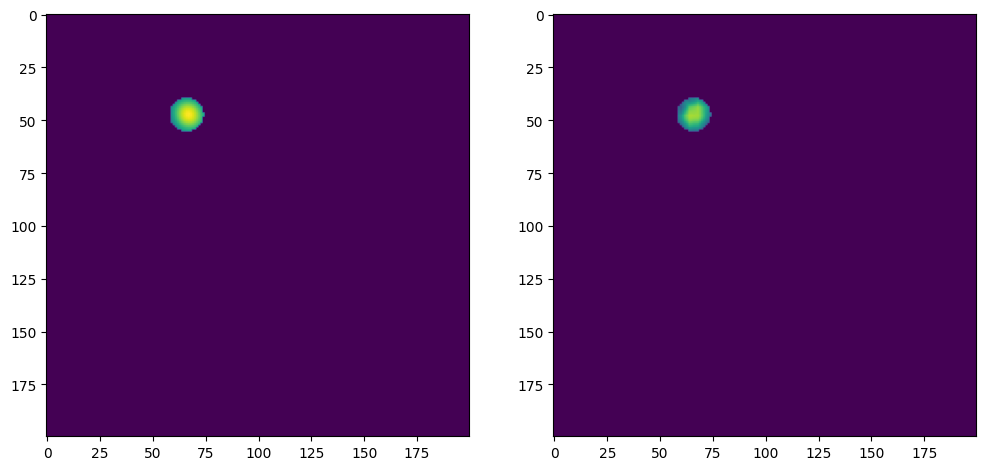

In [77]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask


fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
# STD cleaning
h, w = test_clean[idx].shape[:2]
mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
masked_img1 = test_clean[idx].copy()
masked_img1[~mask] = 0

ax[0].imshow(masked_img1, vmin=0, vmax=1)

# CNN cleaning
h, w = predictions[idx].shape[:2]
mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
masked_img2 = predictions[idx].copy()
masked_img2[~mask] = 0

ax[1].imshow(masked_img2, vmin=0, vmax=1)


plt.show()

In [78]:
np.sum(masked_img1), np.sum(masked_img2)

(145.6675578285042, 119.26021)